In [ ]:
import os
import numpy as np

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18

from sklearn.manifold import TSNE

from google.colab import files
import warnings
warnings.filterwarnings("ignore")


#### downloading data

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mashalsaleem","key":"83b281ba372a84c33b8cbf053f8deb63"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sundarannamalai/hair-diseases

 99% 556M/564M [00:07<00:00, 95.2MB/s]
100% 564M/564M [00:07<00:00, 75.8MB/s]


In [ ]:
! mkdir hair_diseases
! unzip hair-diseases.zip -d hair_diseases > /dev/null


In [ ]:
train_root_path = '/content/hair_diseases/Hair Diseases - Final/train'
val_root_path = '/content/hair_diseases/Hair Diseases - Final/val'

class_paths = [os.path.join(train_root_path, f) for f in os.listdir(train_root_path)]
val_class_paths = [os.path.join(val_root_path, f) for f in os.listdir(val_root_path)]

train_imgs = []
for cls in class_paths:
  train_imgs += [os.path.join(cls, f) for f in os.listdir(cls)]

val_images = []
for cls in val_class_paths:
  val_images += [os.path.join(cls, f) for f in os.listdir(cls)]

class_paths

['/content/hair_diseases/Hair Diseases - Final/train/Telogen Effluvium',
 '/content/hair_diseases/Hair Diseases - Final/train/Head Lice',
 '/content/hair_diseases/Hair Diseases - Final/train/Psoriasis',
 '/content/hair_diseases/Hair Diseases - Final/train/Alopecia Areata',
 '/content/hair_diseases/Hair Diseases - Final/train/Male Pattern Baldness',
 '/content/hair_diseases/Hair Diseases - Final/train/Lichen Planus',
 '/content/hair_diseases/Hair Diseases - Final/train/Contact Dermatitis',
 '/content/hair_diseases/Hair Diseases - Final/train/Folliculitis',
 '/content/hair_diseases/Hair Diseases - Final/train/Seborrheic Dermatitis',
 '/content/hair_diseases/Hair Diseases - Final/train/Tinea Capitis']

In [ ]:

import random
def display_image(img: torch.Tensor):
  plt.imshow(img.permute(1, 2, 0).cpu())

def convert_to_gray(img: torch.Tensor):
  x = transforms.RandomGrayscale(p=0.8)
  return x.forward(img)


def HE_transform(img: torch.Tensor):
  x = transforms.RandomEqualize(p=0.7)
  return x.forward(img)

def normalize_transform(img: torch.Tensor):
  img = img.float()
  x = transforms.Normalize(torch.mean(img), torch.std(img))
  return x.forward(img)

def scale_transform(img: torch.Tensor):
  x = transforms.Resize((420, 420))
  return x.forward(img)

# Flip (Horizontal/Vertical)
def random_flip(img: torch.Tensor):
    if random.random() < 0.5:
        img = transforms.RandomHorizontalFlip()(img)
    if random.random() < 0.5:
        img = transforms.RandomVerticalFlip()(img)
    return img

# Rotation
def random_rotation(img: torch.Tensor):
    return transforms.RandomRotation(degrees=(-30, 30))(img)

def transform_images(img: torch.Tensor):
  return [HE_transform(img), convert_to_gray(img), normalize_transform(img), scale_transform(img), random_rotation(img), random_flip(img)]


In [ ]:
train_imgs[8400], len(train_imgs)

('/content/hair_diseases/Hair Diseases - Final/train/Seborrheic Dermatitis/seborrheic_dermatitis_0150.jpg',
 9600)

In [ ]:
val_images[0], len(val_images)

('/content/hair_diseases/Hair Diseases - Final/val/Telogen Effluvium/telogen_effluvium_0676.jpg',
 1200)

Check preprocessing on selected image

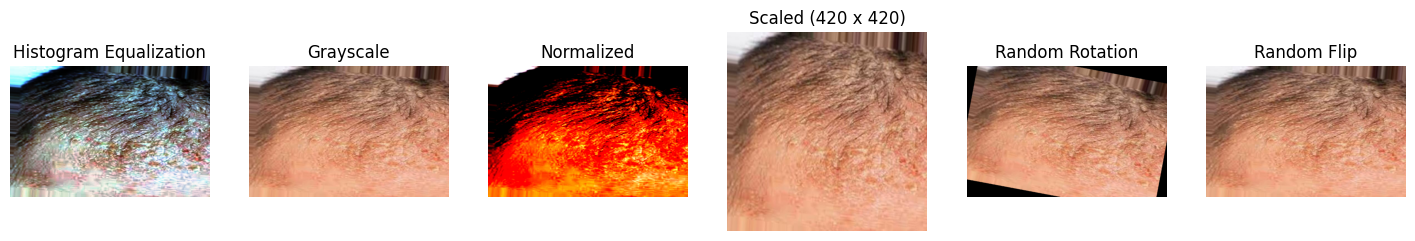

In [ ]:
example = torchvision.io.read_image(train_imgs[8400])
tm_imgs = transform_images(example)


titles = ['Histogram Equalization', 'Grayscale', 'Normalized', 'Scaled (420 x 420)', 'Random Rotation', 'Random Flip']
fig, ax = plt.subplots(1, len(tm_imgs), figsize=(18, 6))

for i in range(len(tm_imgs)):
    ax[i].imshow(tm_imgs[i].permute(1, 2, 0).cpu())
    ax[i].set_title(titles[i])
    ax[i].axis('off')  # Turn off axis labels

plt.show()

## Define the CNN

In [ ]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomEqualize(p=0.7),
    transforms.ToTensor(),

    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    random_rotation
])

# object , apply transformation on images
dataset = ImageFolder(train_root_path, transform=transform)
val_dataset = ImageFolder(val_root_path, transform=transform)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


# just for randomization and 8 bit color

#  CNN Model
class HairDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(HairDiseaseCNN, self).__init__()
        self.resnet = resnet18(pretrained=True)  # Load a pre-trained ResNet model
        # Remove the last fully connected layer of ResNet
        self.resnet = nn.Sequential(*(list(self.resnet.children())[:-1]))
        self.fc = nn.Linear(512, num_classes)    # Add a custom fully connected layer

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    #forward --> subclss if nnmodules

## Train/Fit the model

In [ ]:

# Step 3: Train the CNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(dataset.classes)  # Number of classes in  hair disease dataset
model = HairDiseaseCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()  #instance of loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store training and validation losses
losses = []
epochs = []
val_losses = []

# Lists to store training and validation accuracies
train_accuracies = []
val_accuracies = []

# Number of epochs
num_epochs = 14

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    avg_train_loss = running_loss / len(train_loader)
    losses.append(avg_train_loss)
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    epochs.append(epoch + 1)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Train Acc: {train_accuracy}%, Val Loss: {avg_val_loss}, Val Acc: {val_accuracy}%")

print("Training finished!")

# Step 4: Save the trained model if desired
torch.save(model.state_dict(), "hair_disease_cnn.pth")

Epoch 1/14, Train Loss: 0.7019018992284933, Train Acc: 77.11458333333333%, Val Loss: 0.4799057460929218, Val Acc: 85.08333333333333%


In [ ]:
val_losses

[0.6955489869180479,
 0.10067789134030279,
 0.11278696380261528,
 0.13005967943095847,
 0.19619668775091045,
 0.07669326563757893,
 0.1292005932742828,
 0.016865190408057777,
 0.09600248716857382,
 0.0360831547502465,
 0.3143434331409241,
 0.10777475808955435,
 0.044641935301785306,
 0.00863835159309115]

In [ ]:
losses

[0.7501818682750067,
 0.2516872232283155,
 0.126866121776402,
 0.11905490736632297,
 0.09486148519286265,
 0.10055728070670739,
 0.08160290855312875,
 0.0470243108740154,
 0.054000772212651406,
 0.06616108201482954,
 0.056495855330722405,
 0.0677420992856302,
 0.061368937491885545,
 0.022580597303046186]

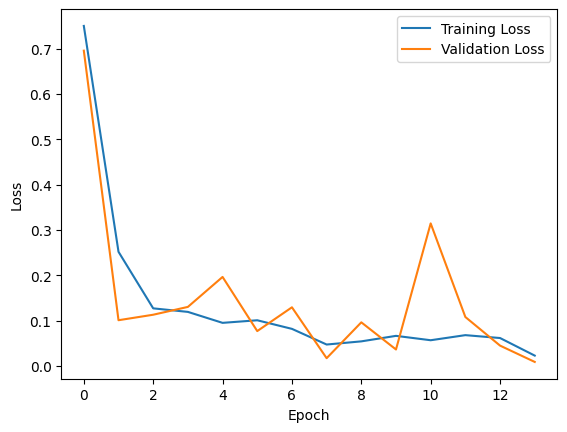

In [ ]:
# Plot the training and validation loss curves
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

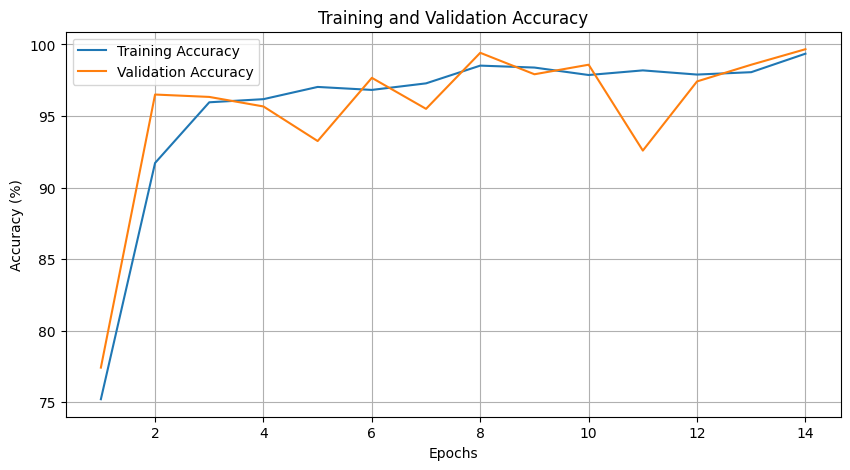

In [ ]:
# Plotting training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),  # Add horizontal flipping
    # transforms.RandomVerticalFlip(),    # Add vertical flipping
    # transforms.RandomRotation(degrees=(-30, 30)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


# Create the dataset and DataLoader without RandomEqualize
data_ext_loader = DataLoader(dataset, batch_size=32, shuffle=False)

model_extractor = HairDiseaseCNN(num_classes).to(device)
model_extractor.load_state_dict(torch.load("hair_disease_cnn.pth"))

model_extractor.eval()

#  Feature Extraction
all_features = []
with torch.no_grad(): #
    for inputs, labels in data_ext_loader:
        inputs = inputs.to(device)
        features = model_extractor(inputs) #
        all_features.append(features)

# Concatenate features from all batches into a single tensor
features_tensor = torch.cat(all_features)

# Now 'features_tensor' contains the extracted features from the model
print(features_tensor.shape)

FileNotFoundError: ignored

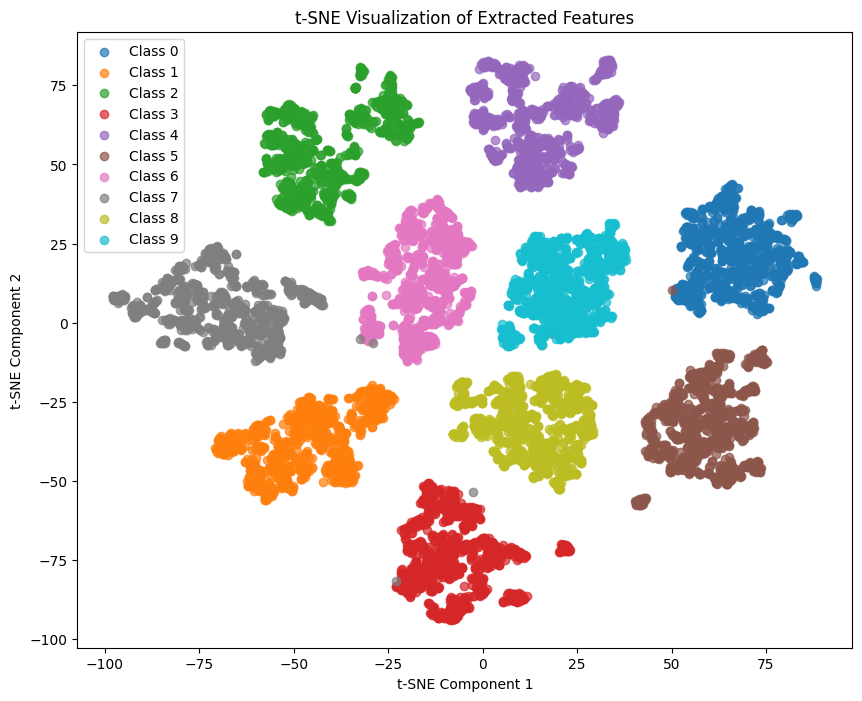

In [ ]:
features_np = features_tensor.cpu().numpy()
features_np = (features_np - features_np.mean(axis=0)) / features_np.std(axis=0)

# Perform t-SNE on the features
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(features_np)

class_labels = np.array([y for _, y in dataset])

# Create a scatter plot for each class
plt.figure(figsize=(10, 8))
for class_idx in np.unique(class_labels):
    class_mask = (class_labels == class_idx)
    plt.scatter(embedded_features[class_mask, 0], embedded_features[class_mask, 1], label=f"Class {class_idx}", alpha=0.7)

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.title("t-SNE Visualization of Extracted Features")
plt.show()

## Model Evaluation

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

validation_root_path = '/content/hair_diseases/Hair Diseases - Final/val'
validation_dataset = ImageFolder(validation_root_path, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

model.eval()  # Set the model to evaluation mode
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions, target_names=dataset.classes)

print(f"Validation Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)

# Step 5: Save the trained model if desired
torch.save(model.state_dict(), "hair_disease_cnn.pth")

Validation Accuracy: 0.9983333333333333
Classification Report:
                       precision    recall  f1-score   support

      Alopecia Areata       1.00      1.00      1.00       120
   Contact Dermatitis       1.00      1.00      1.00       120
         Folliculitis       1.00      1.00      1.00       120
            Head Lice       0.98      1.00      0.99       120
        Lichen Planus       1.00      1.00      1.00       120
Male Pattern Baldness       1.00      1.00      1.00       120
            Psoriasis       1.00      1.00      1.00       120
Seborrheic Dermatitis       1.00      0.98      0.99       120
    Telogen Effluvium       1.00      1.00      1.00       120
        Tinea Capitis       1.00      1.00      1.00       120

             accuracy                           1.00      1200
            macro avg       1.00      1.00      1.00      1200
         weighted avg       1.00      1.00      1.00      1200



### Model summary

In [ ]:
from torchsummary import summary

# ... Your code up to model definition ...

# Display model summary
summary(model, (3, 224, 224))  # Assuming input image size is 224x224 and has 3 channels


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### Confussion Matrix

confusion matrix as a heatmap


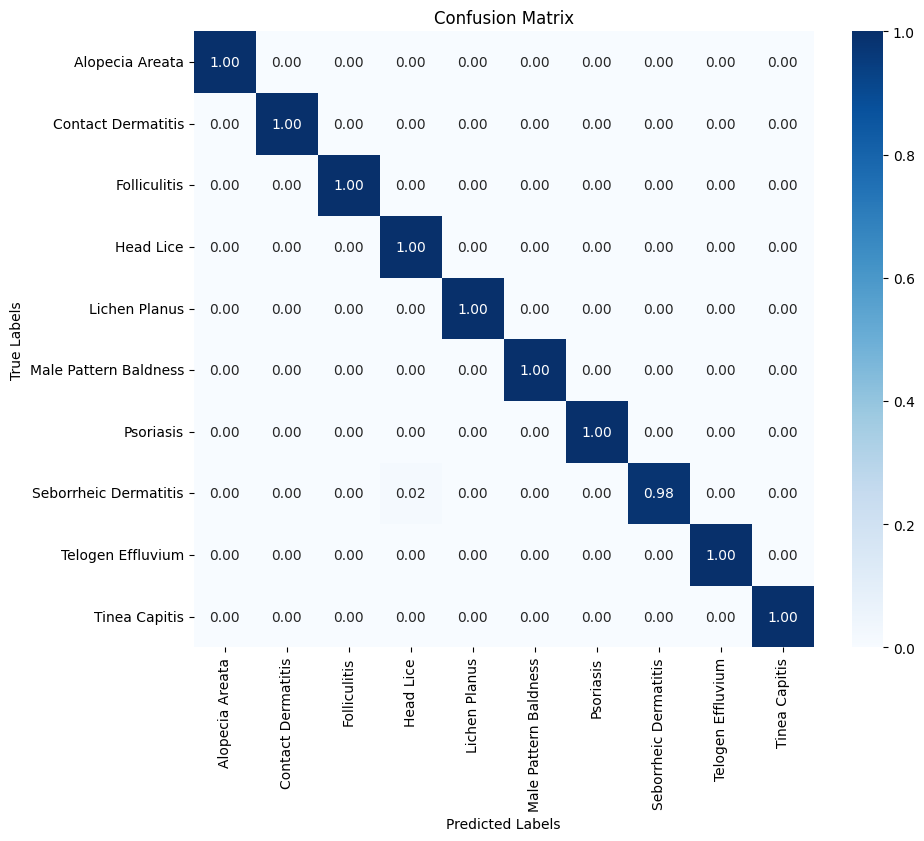

 bar chart for accuracy per class


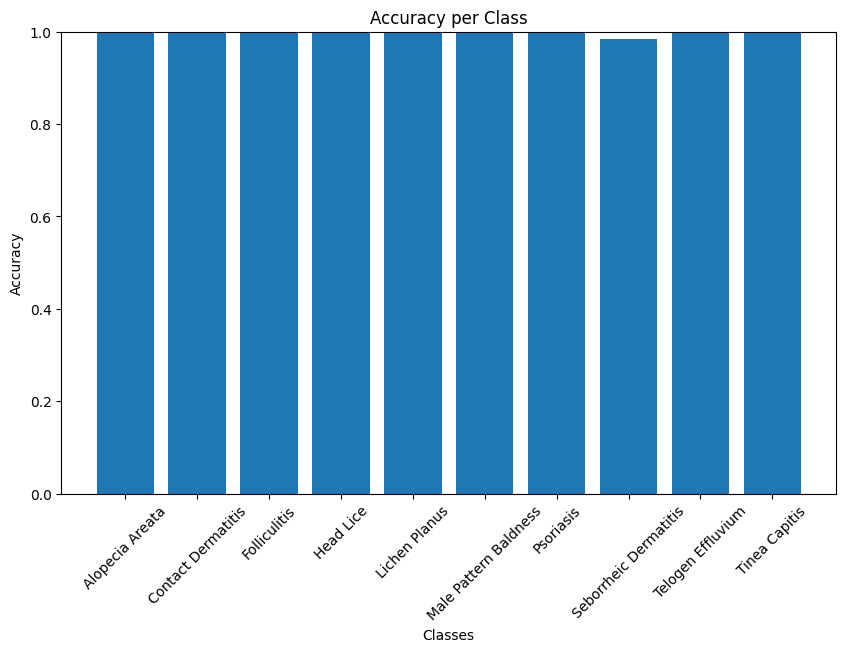

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions, normalize='true')  # Normalize to show relative frequencies
class_names = dataset.classes

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
print('confusion matrix as a heatmap')
plt.show()


# Plot a bar chart for accuracy per class
class_accuracy = conf_matrix.diagonal()
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_accuracy)
plt.xlabel("Classes")
plt.ylabel("Accuracy")
plt.title("Accuracy per Class")
plt.xticks(rotation=45)
plt.ylim(0, 1)

print(' bar chart for accuracy per class')
plt.show()


## Calculate precision & F1 Score

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc


precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Weighted Precision: {precision:.2f}")
print(f"Weighted Recall: {recall:.2f}")
print(f"Weighted F1-score: {f1:.2f}")


Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1-score: 1.00


## Error Analysis

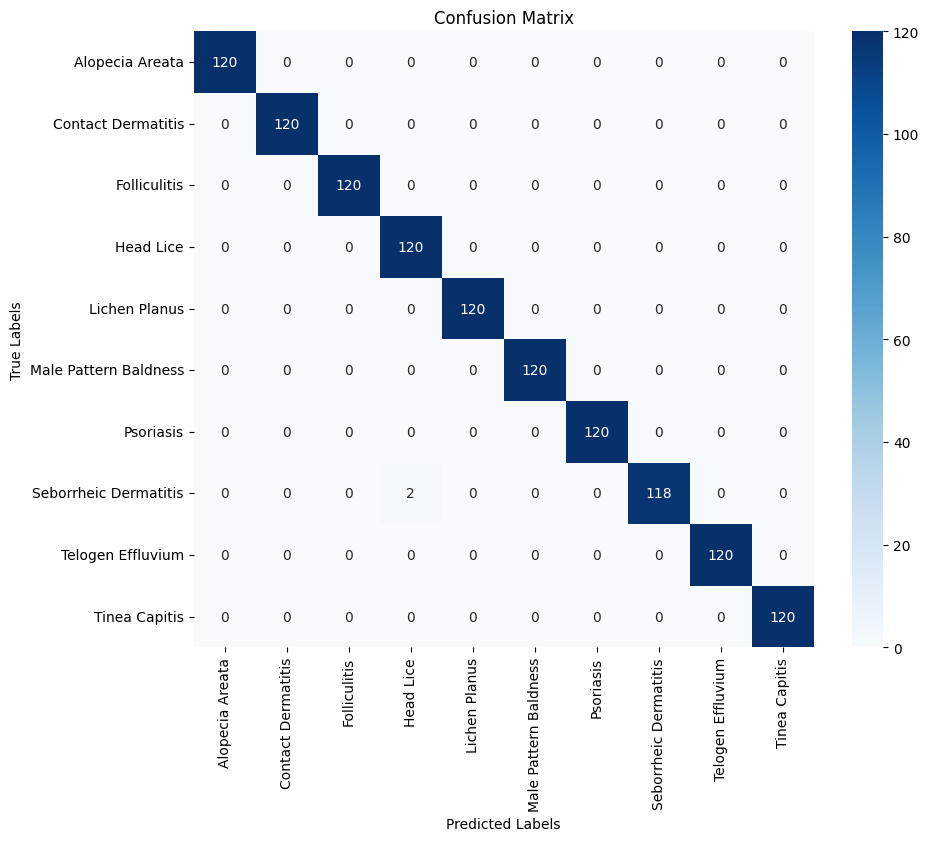

Detailed Analysis of Misclassified Images:
Image 844: Actual = Seborrheic Dermatitis, Predicted = Head Lice
Image 921: Actual = Seborrheic Dermatitis, Predicted = Head Lice


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# ... Your code up to model evaluation ...

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
class_names = dataset.classes

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Display a detailed analysis of misclassified images
print("Detailed Analysis of Misclassified Images:")
print("=" * 40)

for i in range(len(all_labels)):
    if all_labels[i] != all_predictions[i]:
        actual_class = dataset.classes[all_labels[i]]
        predicted_class = dataset.classes[all_predictions[i]]
        print(f"Image {i + 1}: Actual = {actual_class}, Predicted = {predicted_class}")

# ... Continue with other parts of your code ...


### Test classification

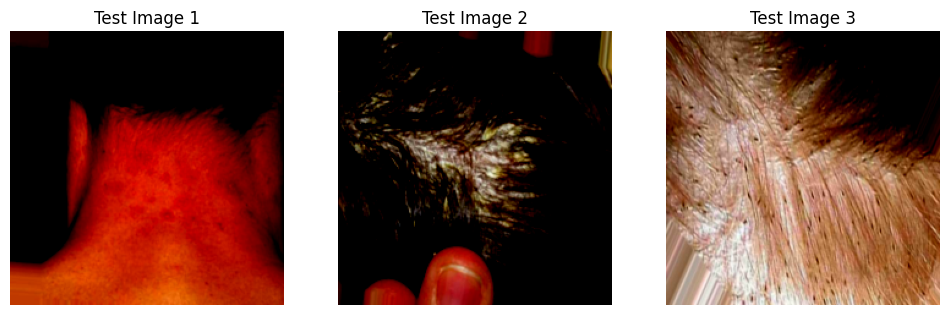

In [ ]:
# Load a few validation images for testing
test_images = [
    "/content/hair_diseases/Hair Diseases - Final/tes/Folliculitis/folliculitis_0016.jpg",
    "/content/hair_diseases/Hair Diseases - Final/test/Psoriasis/psoriasis_0029.jpg",
    "/content/hair_diseases/Hair Diseases - Final/val/Head Lice/head_lice_0043.jpg"
]

# Load and transform the test images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_images_tensor = [transform(Image.open(img_path)) for img_path in test_images]

# Display the transformed images
plt.figure(figsize=(12, 6))
for i in range(len(test_images)):
    plt.subplot(1, len(test_images), i + 1)
    plt.imshow(test_images_tensor[i].permute(1, 2, 0))
    plt.title(f"Test Image {i + 1}")
    plt.axis("off")

plt.show()


####  Classify the test images

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for i, test_img in enumerate(test_images_tensor):
        test_img = test_img.unsqueeze(0).to(device)
        output = model(test_img)
        _, predicted_class = torch.max(output, 1)
        class_name = dataset.classes[predicted_class.item()]
        confidence = torch.softmax(output, dim=1)[0][predicted_class].item() * 100

        print(f"Test Image {i + 1} - Classification: {class_name}, Confidence: {confidence:.2f}%")

Test Image 1 - Classification: Folliculitis, Confidence: 100.00%
Test Image 2 - Classification: Psoriasis, Confidence: 100.00%
Test Image 3 - Classification: Head Lice, Confidence: 99.99%


### Testing using interactive Widgets

In [ ]:
from IPython.display import display
import ipywidgets as widgets
from IPython.display import Image as IPImage
from PIL import Image
import numpy as np
import io


# Load the model and set it to evaluation mode
model = HairDiseaseCNN(num_classes).to(device)
model.load_state_dict(torch.load("hair_disease_cnn.pth"))
model.eval()

# Create an image uploader widget
uploader = widgets.FileUpload(
    accept='image/*',  # Specify accepted file formats
    multiple=False,  # Allow only one file to be uploaded
    description="Upload an image"
)

# Define a function to handle the uploaded image
def on_upload_change(change):
    print("Uploaded")
    img = uploader.data[0]
    img = Image.open(io.BytesIO(img))
    img = transform(img)
    img = img.unsqueeze(0).to(device)

    model.eval()

    with torch.no_grad():

      output = model(img.to(device))
      print("Predicted")

      _, predicted_class = torch.max(output, 1)
      class_name = dataset.classes[predicted_class.item()]
      confidence = torch.softmax(output, dim=1)[0][predicted_class].item() * 100

    display(IPImage(data=uploader.data[0]))
    print(f"Classification: {class_name}, Confidence: {confidence:.2f}%")



# Attach the function to the uploader's change event
uploader.observe(on_upload_change, names="data")

# Display the uploader widget
display(uploader)


FileUpload(value={}, accept='image/*', description='Upload an image')